In [1]:
!pip install nbconvert[webpdf]
!playwright install chromium

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Plotting program
import matplotlib.pyplot as plt

# System
import os
import sys
from glob import glob

# Good for reading/writing data tables
import pandas as pd

# Better math, numbers, and array functions
import numpy as np

# Astropy
from astropy.timeseries import LombScargle
from astropy.io import fits, ascii
from astropy.table import Table, join

# Download TESS
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
import astropy.units as units

from astroquery.vizier import Vizier # then we import the Vizier() tool
from astroquery.xmatch import XMatch # ...and the Xmatch() tool

# TESS cpm
import tess_cpm as tess_cpm

Could not import regions, which is required for some of the functionalities of this module.


In [3]:
#SetUpDirectories
dir_lightcurve = 'LightCurves/'  
dir_ffi = 'FFI_Cutouts/' 

In [4]:
import os
from glob import glob
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord

def download_tess(target_data, dir_ffi):
    files_ffi = glob(dir_ffi + "*" + str(target_data['GaiaDR2']) + "*.fits")
    
    print("Initial files_ffi:", files_ffi)  # Debugging print
    
    if len(files_ffi) == 0:
        os.mkdir(dir_ffi + str(target_data['GaiaDR2']) + '/')
        cutout_coord = SkyCoord(target_data['RA_ICRS'], target_data['DE_ICRS'], unit="deg")
        manifest = Tesscut.download_cutouts(coordinates=cutout_coord, size=40, path=dir_ffi + str(target_data['GaiaDR2']) + '/')
        dl_files = glob(dir_ffi + str(target_data['GaiaDR2']) + "/*")
        
        print("Downloaded files:", dl_files)  # Debugging print
        
        for d in dl_files:
            print(f"Filename: {d}, Length: {len(d)}")  # Debugging print
            try:
                sector = d.split('-')[1].split('s')[1].split('_')[0]
                print("Parsed sector from downloaded file:", sector)  # Debugging print
                os.rename(d, dir_ffi + str(target_data['GaiaDR2']) + '-Sector_' + sector + '.fits')
            except (IndexError, ValueError) as e:
                print("Error parsing sector number from filename:", d, "Error:", e)
                continue
        os.rmdir(dir_ffi + str(target_data['GaiaDR2']) + '/')
        files_ffi = glob(dir_ffi + str(target_data['GaiaDR2']) + "*")
    else:
        downloaded_sectors = []
        for f in files_ffi:
            print(f"Filename: {f}, Length: {len(f)}")  # Debugging print
            try:
                sector = f.split('-')[1].split('s')[1].split('_')[0]
                print("Parsed sector from existing file:", sector)  # Debugging print
                downloaded_sectors.append(int(sector))
            except (IndexError, ValueError) as e:
                print("Error parsing sector number from filename:", f, "Error:", e)
                continue
        os.mkdir(dir_ffi + str(target_data['GaiaDR2']) + '/')
        cutout_coord = SkyCoord(target_data['RA_ICRS'], target_data['DE_ICRS'], unit="deg")
        available_sectors = Tesscut.get_sectors(coordinates=cutout_coord)
        for s in available_sectors['sector']:
            if not (s in downloaded_sectors):
                manifest = Tesscut.download_cutouts(coordinates=cutout_coord, size=40, path=dir_ffi + str(target_data['GaiaDR2']) + '/', sector=s)
        dl_files = glob(dir_ffi + str(target_data['GaiaDR2']) + "/*")
        
        print("Additional downloaded files:", dl_files)  # Debugging print
        
        for d in dl_files:
            try:
                sector = d.split('-')[1].split('s')[1].split('_')[0]
                print("Parsed sector from additional downloaded file:", sector)  # Debugging print
                os.rename(d, dir_ffi + str(target_data['GaiaDR2']) + '-Sector_' + sector + '.fits')
            except (IndexError, ValueError) as e:
                print("Error parsing sector number from filename:", d, "Error:", e)
                continue
        os.rmdir(dir_ffi + str(target_data['GaiaDR2']) + '/')
        files_ffi = glob(dir_ffi + str(target_data['GaiaDR2']) + "*")
        
    # Check data sizes
    files = glob(dir_ffi + '*')
    for file in files:
        bsize = os.path.getsize(file)  # size in bytes
        if bsize < 200:
            os.remove(file)
            
    return files_ffi


In [5]:
def cpm_do(file, t_row=20, t_col=20, excl=4):
    # Causal pixel modeling procedure to generate light curves from FFI without systematics
    # Our FFI cutouts are 40x40, so our target is on pixel (20,20)
    # Exclusion zone set to 4 pixels for systematics modeling
    
    cpm = tess_cpm.CPM(file, remove_bad=True)
    cpm.set_target(t_row, t_col)
    cpm.set_exclusion(excl)
    cpm.set_predictor_pixels(256, method='similar_brightness') # cosine_similarity
    cpm.lsq(0.1, rescale=True, polynomials=False)
    # tess_cpm.summary_plot(cpm, 15)
    # aperture_lc, lc_matrix = cpm.get_aperture_lc(box=1, show_pixel_lc=True, show_aperture_lc=True)
    time = cpm.time
    flux = cpm.rescaled_target_fluxes - cpm.lsq_prediction
    return time, flux

def make_cpm(target_data, dir_lightcurve, dir_ffi, excl=4, mad_cut=20):
    # First check if we have all FFIs downloaded for a target
    files = download_tess(target_data, dir_ffi)
    
    print("Files for light curve generation:", files)  # Debugging print

    lc_list = []

    # Then check for each FFI if light curves exist
    # If not, make 5x5 light curve grid centered on target
    for f in files:
        try:
            csv_file = dir_lightcurve + f.split('/')[-1].replace('.fits', '.csv')
            lc_test = glob(csv_file)
            if np.size(lc_test) == 0:
                time, flux = [], []
                lc_table = Table()
                rows = range(18, 23)
                cols = range(18, 23)
                for r in rows:
                    for c in cols:
                        flux_name = 'Flux_' + str(r) + '_' + str(c)
                        this_time, this_flux = cpm_do(f, t_row=r, t_col=c, excl=excl)
                        mad = np.nanmedian(np.abs(this_flux * 100))
                        if mad < mad_cut:
                            time = this_time
                            flux = this_flux
                        else:
                            time = this_time
                            flux = np.zeros(len(this_flux))
                        lc_table['Time'] = time
                        lc_table[flux_name] = flux

                ascii.write(lc_table, csv_file, format='csv', overwrite=True)
            lc_list.append(csv_file)
        except Exception as e:
            print(f"Error generating light curve for file {f}: {e}")  # Debugging print

    lc_files = glob(dir_lightcurve + "*" + str(target_data['GaiaDR2']) + "*.csv")
    return lc_files

def LS_Period(time, flux, pmin=0.1, pmax=30.0):
    fmax = 1/pmin # 0.1 days
    fmin = 1/pmax # 50 days
    freq, power = LombScargle(time, flux).autopower(minimum_frequency=fmin, maximum_frequency=fmax)
    return 1/freq[np.argmax(power)], np.max(power)


In [6]:
# download the catalog

vizier_code = 'J/ApJ/904/140/table5'

query_catalog = Vizier()

query_catalog.ROW_LIMIT = -1

curtis_rot = query_catalog.get_catalogs(vizier_code)[0]

curtis_rot

<Table length=923>
  Cluster      Age      Av   ... Simbad  _RA.icrs   _DE.icrs 
               Gyr     mag   ...           deg        deg    
   str12     float32 float32 ...  str6   float64    float64  
------------ ------- ------- ... ------ ---------- ----------
    Pleiades   0.120   0.120 ... Simbad  53.882158  22.823390
    Pleiades   0.120   0.120 ... Simbad  54.046203  23.806264
    Pleiades   0.120   0.120 ... Simbad  54.101510  22.623601
    Pleiades   0.120   0.120 ... Simbad  54.160077  23.145484
    Pleiades   0.120   0.120 ... Simbad  54.485193  23.382239
    Pleiades   0.120   0.120 ... Simbad  54.594179  22.499485
         ...     ...     ... ...    ...        ...        ...
Ruprecht 147   2.700   0.300 ... Simbad 289.266390 -16.135371
Ruprecht 147   2.700   0.300 ... Simbad 289.460250 -16.624023
Ruprecht 147   2.700   0.300 ... Simbad 288.586900 -16.749012
Ruprecht 147   2.700   0.300 ... Simbad 288.978840 -17.770926
Ruprecht 147   2.700   0.300 ... Simbad 288.383960 -16.286807
Ruprecht 147   2.700   0.300 ... Simbad 289.379180 -16.954553

In [7]:
praesepe_index = np.where(curtis_rot['Cluster'] == 'Praesepe')[0]
praesepe_targets = curtis_rot[praesepe_index]

# Define the BP-RP range
bp_rp_min = 0.6
bp_rp_max = 1.0

# Filter the targets within the BP-RP range from the Praesepe cluster
filtered_indices = np.where((praesepe_targets['BP-RP'] >= bp_rp_min) & (praesepe_targets['BP-RP'] <= bp_rp_max))[0]
filtered_targets = praesepe_targets[filtered_indices]

selected_targets = filtered_targets[:3]
print(f"Number of targets in Praesepe cluster between {bp_rp_min} and {bp_rp_max} BP-RP: {len(selected_targets)}")

Number of targets in Praesepe cluster between 0.6 and 1.0 BP-RP: 3


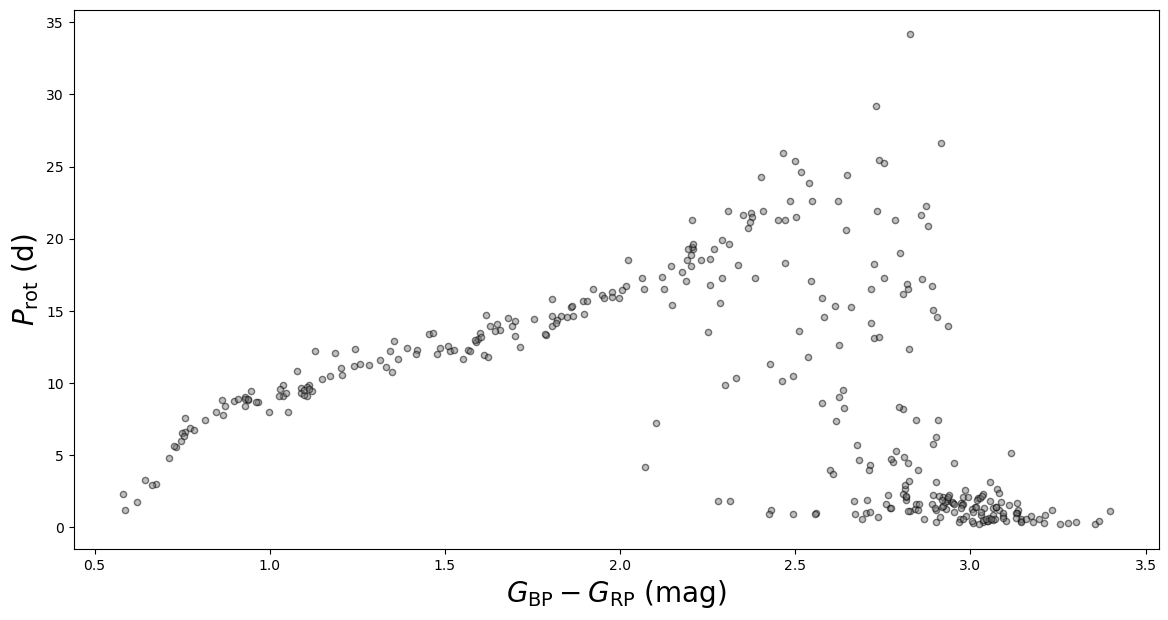

In [8]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(curtis_rot['BP-RP'][praesepe_index], curtis_rot['Prot'][praesepe_index], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel(r'$P_{\rm rot}$ (d)', fontsize = 20)
ax.set_xlabel(r'$G_{\rm BP}-G_{\rm RP}$ (mag)', fontsize = 20)

plt.show()

In [83]:
for target_data in selected_targets:
    download_tess(target_data, dir_ffi)

Initial files_ffi: []
Downloaded files: ['FFI_Cutouts/664327433763175424/tess-s0046-1-2_129.979270_20.064971_40x40_astrocut.fits', 'FFI_Cutouts/664327433763175424/tess-s0044-4-4_129.979270_20.064971_40x40_astrocut.fits', 'FFI_Cutouts/664327433763175424/tess-s0072-2-2_129.979270_20.064971_40x40_astrocut.fits', 'FFI_Cutouts/664327433763175424/tess-s0045-2-2_129.979270_20.064971_40x40_astrocut.fits']
Filename: FFI_Cutouts/664327433763175424/tess-s0046-1-2_129.979270_20.064971_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0046
Filename: FFI_Cutouts/664327433763175424/tess-s0044-4-4_129.979270_20.064971_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0044
Filename: FFI_Cutouts/664327433763175424/tess-s0072-2-2_129.979270_20.064971_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0072
Filename: FFI_Cutouts/664327433763175424/tess-s0045-2-2_129.979270_20.064971_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0045

In [84]:
# Run the make_cpm function and check the output
for target_data in selected_targets:
    lc_list = make_cpm(target_data, dir_lightcurve, dir_ffi)

Initial files_ffi: ['FFI_Cutouts/664327433763175424-Sector_0044.fits', 'FFI_Cutouts/664327433763175424-Sector_0072.fits', 'FFI_Cutouts/664327433763175424-Sector_0045.fits', 'FFI_Cutouts/664327433763175424-Sector_0046.fits']
Filename: FFI_Cutouts/664327433763175424-Sector_0044.fits, Length: 47
Parsed sector from existing file: 
Error parsing sector number from filename: FFI_Cutouts/664327433763175424-Sector_0044.fits Error: invalid literal for int() with base 10: ''
Filename: FFI_Cutouts/664327433763175424-Sector_0072.fits, Length: 47
Parsed sector from existing file: 
Error parsing sector number from filename: FFI_Cutouts/664327433763175424-Sector_0072.fits Error: invalid literal for int() with base 10: ''
Filename: FFI_Cutouts/664327433763175424-Sector_0045.fits, Length: 47
Parsed sector from existing file: 
Error parsing sector number from filename: FFI_Cutouts/664327433763175424-Sector_0045.fits Error: invalid literal for int() with base 10: ''
Filename: FFI_Cutouts/6643274337631754

In [85]:
# open the lightcurve file for Sector 72

lc_table = ascii.read(lc_list[0])

lc_table

<Table length=3121>
       Time              Flux_18_18       ...        Flux_22_22      
     float64              float64         ...         float64        
------------------ ---------------------- ... -----------------------
 2525.796516042703 -6.773457568343133e-05 ...    0.009857676300312868
 2525.845131840259   0.004019776938629871 ...    0.008003338007183114
2525.8590220710603  -0.009582385786225167 ...  -0.0010004490941439848
 2525.865967186925 -0.0064514356891289815 ... -0.00013772034370962416
2525.8729123030225   0.005009986138711842 ...    0.004712419807424206
 2525.893747653182 -0.0036415687420547904 ...    0.002385152471585217
               ...                    ... ...                     ...
 2550.583439617276  -0.006599735029180515 ...   -0.002549993721922293
 2550.590384560148  -0.004688266604165284 ...  -0.0035646924235324257
2550.5973295027898   0.002552757618435958 ...    0.004093199206214315
2550.6042744451975  0.0015757850915654459 ...   0.0025036406784816057
2550.6112193873723 -0.0070355484801159635 ...  0.00027904425987922143
 2550.618164329314   0.004326178913330578 ...  -0.0015621046479619566
2550.6251092712555 -0.0010177578914437602 ...   -0.001951434561968099

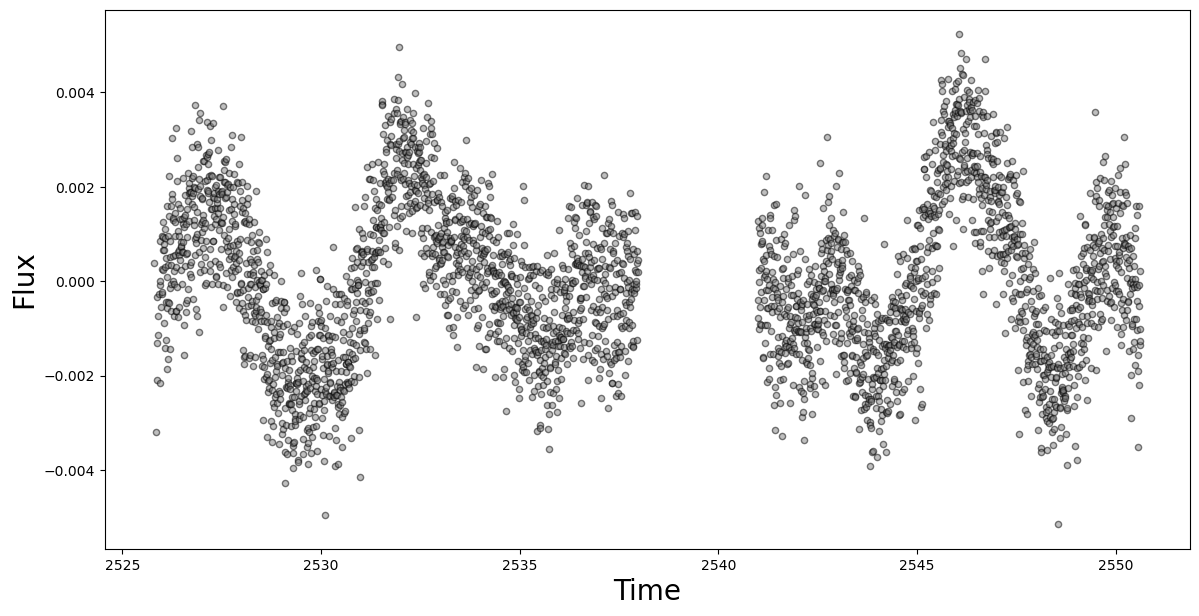

In [86]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

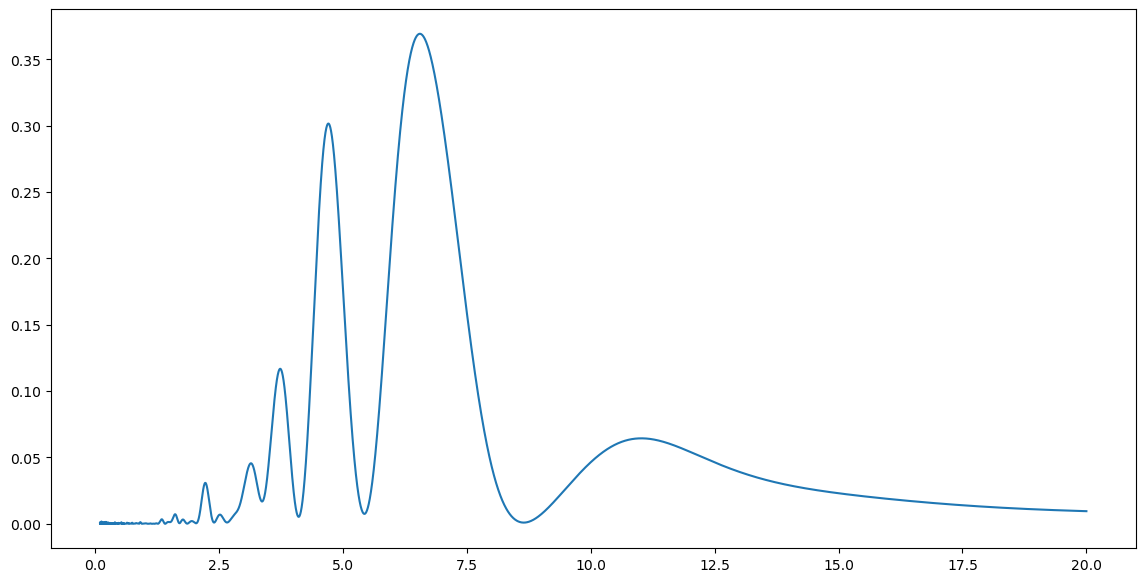

In [87]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [88]:
# open the lightcurve file for Sector 44

lc_table = ascii.read(lc_list[1])

lc_table

<Table length=3261>
       Time               Flux_18_18       ...        Flux_22_22      
     float64               float64         ...         float64        
------------------ ----------------------- ... -----------------------
  2500.18888367721    0.007623923276832922 ...    0.015532007706140494
 2500.195828747933     0.00452755904430413 ...    0.003294351731012224
2500.2027738193556   0.0016633045148339853 ...   -0.005399262732731724
 2500.209718891011    0.002493741880405409 ...  -0.0027312034877615687
 2500.216663963131    0.008215001003969213 ...  -0.0010025185990332197
 2500.223609035717  -0.0017245864378305775 ...  -0.0009971538246553724
               ...                     ... ...                     ...
 2524.392618343175 -0.00021357173672778562 ...    0.002846351944665676
 2524.399563433457   -0.002052664204304111 ...    0.002675189636617503
2524.4065085235197   0.0035085546123398703 ...   0.0006672015413723142
2524.4134536133656  0.00020125350172772727 ...   0.0009018345064256972
 2524.420398703008  -0.0020357876510134765 ... -0.00044591000854768414
2524.4273437924167   0.0005325989060773195 ...  -0.0003601301115027655
 2524.434288881622    0.004087477073630469 ...  -0.0025525497999238644

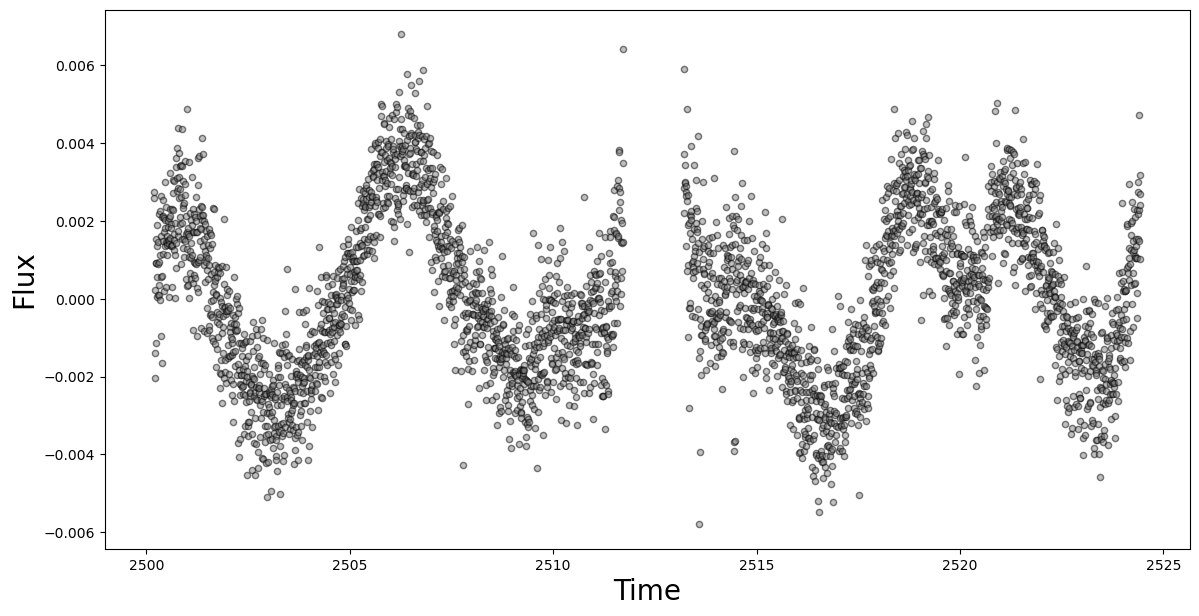

In [89]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

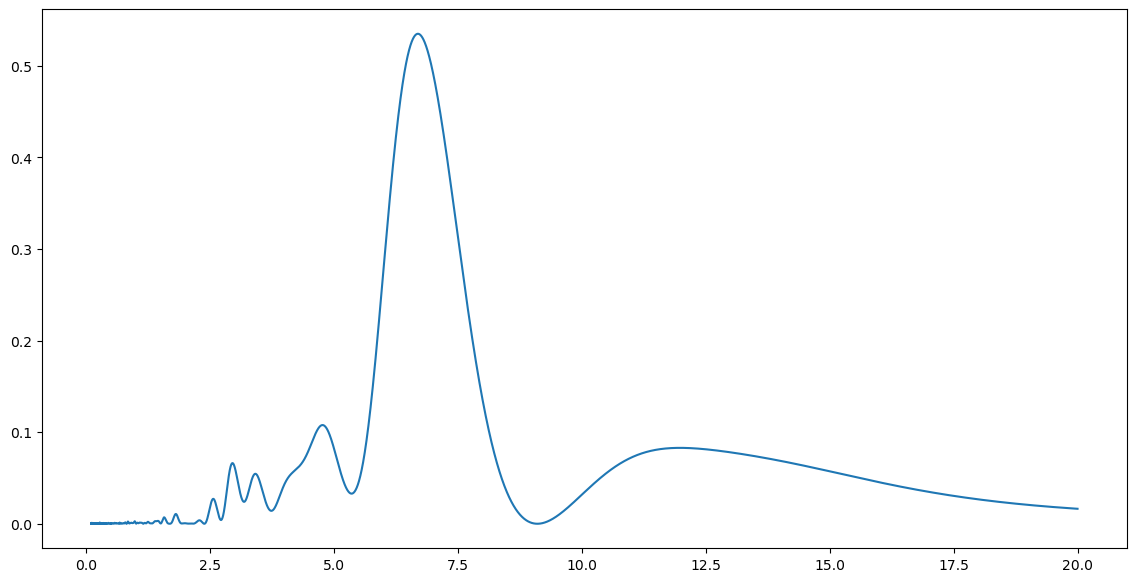

In [90]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [91]:
# open the lightcurve file for Sector 45

lc_table = ascii.read(lc_list[2])

lc_table

<Table length=3320>
       Time              Flux_18_18       ...       Flux_22_22      
     float64              float64         ...        float64        
------------------ ---------------------- ... ----------------------
 2552.076282876147   0.003870161801543759 ...    0.00603342260449935
2552.0832278795297 -0.0038574024281849972 ...  0.0038379984220657803
2552.1318429118137  0.0012750500029063971 ...  -0.004015724656897035
 2552.152677929177   0.004865907537204173 ... -6.856127163690218e-05
 2552.180457955741   0.015904967369022138 ...  0.0041077796284358925
 2552.201292977994   0.007975545197291822 ...   -0.01401352881505602
               ...                    ... ...                    ...
 2578.661329560993   0.003834420714120155 ... -0.0018826317116380576
2578.6682742719404  0.0008672975153659057 ...   0.002504434682156056
2578.6752189828867  0.0012325207151079641 ... -0.0025882078951418534
 2578.682163693833 -0.0005934109525086257 ...  -0.002037160410740313
  2578.68910840478   -0.00616456366809125 ...   0.001286472566941138
 2578.696053115726   -0.00704548371030584 ... -0.0008255846507366267
 2578.702997826673   0.002150738697145144 ...  0.0008902880488223745

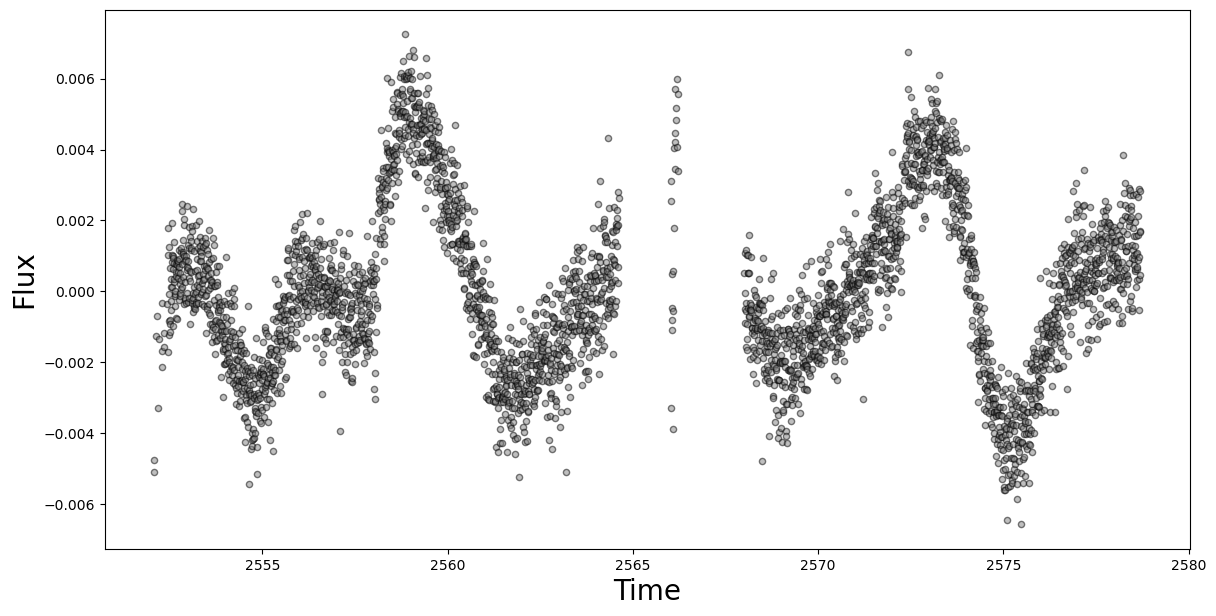

In [92]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

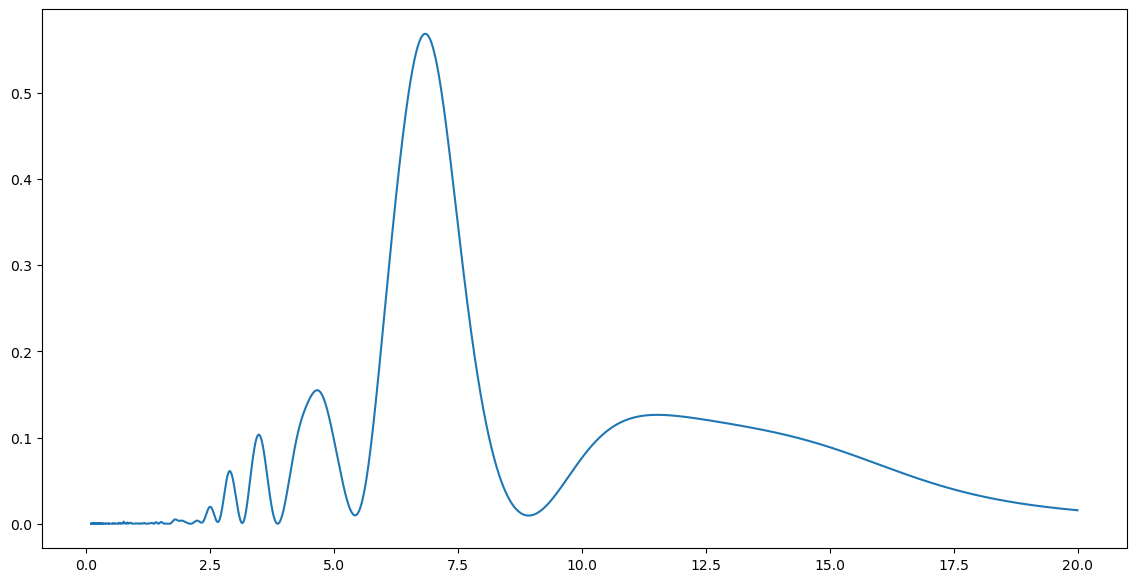

In [93]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [94]:
# open the lightcurve file for Sector 46

lc_table = ascii.read(lc_list[3])

lc_table

<Table length=9577>
       Time              Flux_18_18      ...      Flux_22_21      Flux_22_22
     float64              float64        ...       float64         float64  
------------------ --------------------- ... -------------------- ----------
3260.1873670193495    0.2110888821642618 ...  0.22857725289151176        0.0
3260.1896820438214    1.0509406609365612 ...  0.02049547616222469        0.0
 3260.191997068409    -0.631355366320463 ...  0.06138799402980055        0.0
3260.1943120928804  0.007963119096501714 ...  -0.2257011877278785        0.0
 3260.196627117469     0.197604346662132 ... -0.02938553546451317        0.0
 3260.198942142173   -0.7812267005935638 ...  0.22304896450594924        0.0
               ...                   ... ...                  ...        ...
3285.5715629016936  0.024363702590352698 ... 0.037075714907820634        0.0
 3285.573877880996  0.042917683493417846 ... -0.08577634340442442        0.0
3285.5761928602988 -0.045763712096212744 ... -0.02702999638629766        0.0
 3285.578507839601  -0.15274036999200213 ... -0.09056067281453462        0.0
3285.5808228186706   -0.0415930713793107 ...  0.09993328285621991        0.0
3285.5831377979734   0.06165733900340273 ... -0.05861121534052379        0.0
3285.5854527770434  0.006940137273399066 ...  -0.0641848332578806        0.0

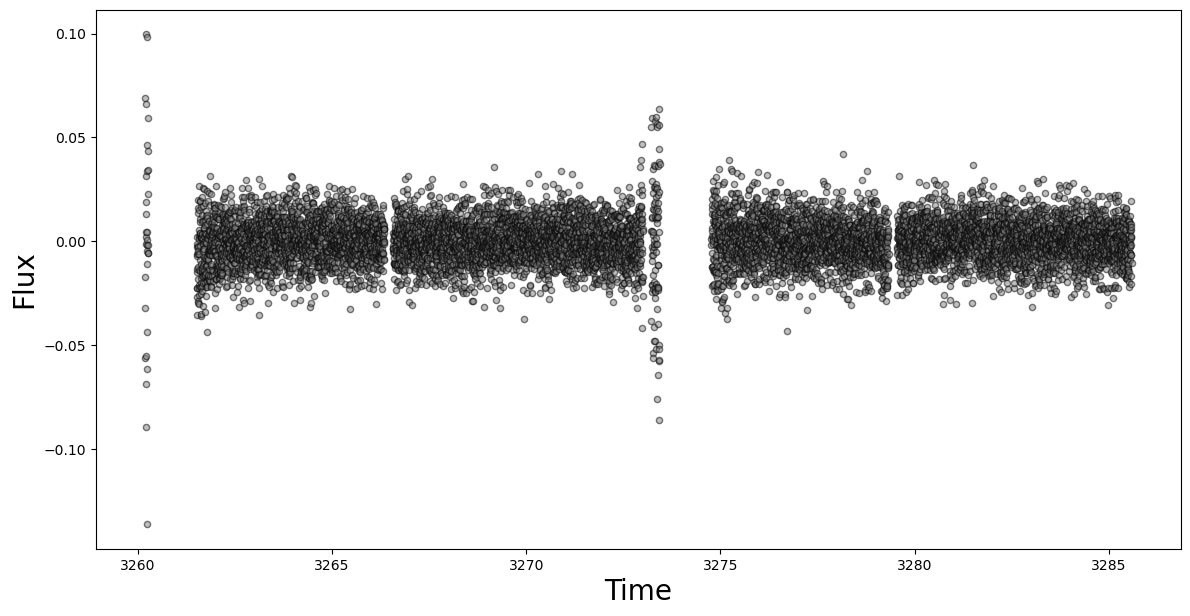

In [95]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

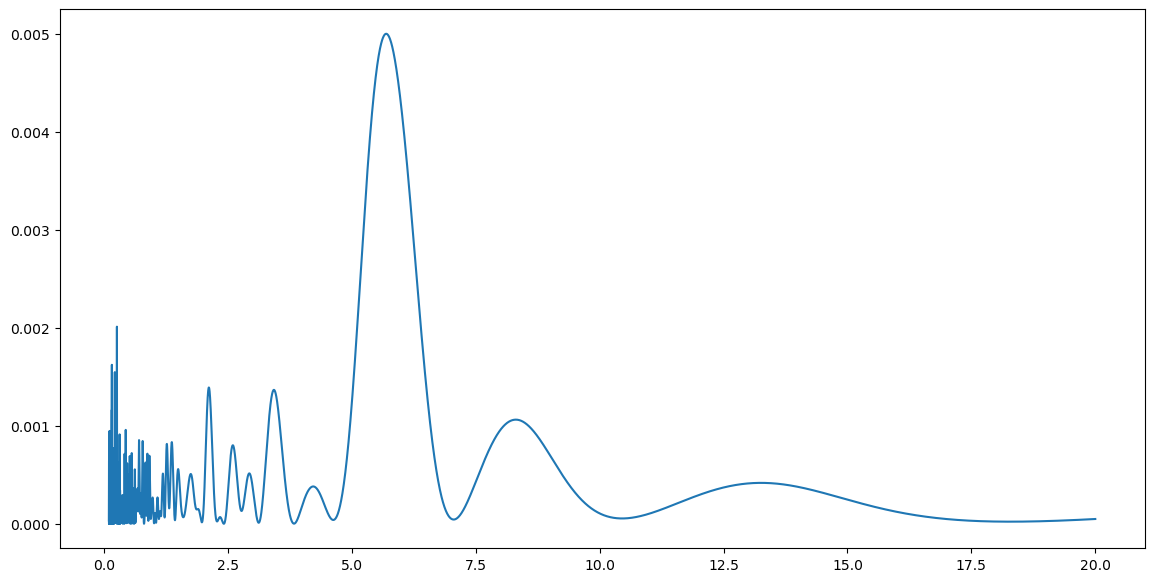

In [96]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [97]:
for target_data in selected_targets:
    gaia_id = target_data['GaiaDR2']
    lc_files = glob(os.path.join(dir_lightcurve, f"{gaia_id}-Sector_*.csv"))
    
    for lc_file in lc_files:
        lc_table = ascii.read(lc_file)
        time = lc_table['Time']
        
        # Combine all flux columns into a single flux array
        flux_columns = [col for col in lc_table.colnames if col.startswith('Flux_')]
        flux = np.sum([lc_table[col] for col in flux_columns], axis=0)
        
        # Calculate period and power
        period, power = LS_Period(time, flux, pmax=20.0)
        
        # Print the results
        print(f"Results for target {gaia_id} from file {lc_file}:")
        print('Our period: ' + str(period))
        print('Our power: ' + str(power))
        print('Curtis period: ' + str(target_data['Prot']))

Results for target 664327433763175424 from file LightCurves/664327433763175424-Sector_0072.csv:
Our period: 0.11964996094429164
Our power: 0.0016158618144529078
Curtis period: 3.29
Results for target 664327433763175424 from file LightCurves/664327433763175424-Sector_0044.csv:
Our period: 3.0260343719040095
Our power: 0.08152534886770414
Curtis period: 3.29
Results for target 664327433763175424 from file LightCurves/664327433763175424-Sector_0045.csv:
Our period: 3.0126560862076945
Our power: 0.21929888357420452
Curtis period: 3.29
Results for target 664327433763175424 from file LightCurves/664327433763175424-Sector_0046.csv:
Our period: 3.1959719014362826
Our power: 0.17005200017194244
Curtis period: 3.29
Results for target 661311752544249088 from file LightCurves/661311752544249088-Sector_0046.csv:
Our period: 3.1210487710844386
Our power: 0.3274387190199483
Curtis period: 2.99
Results for target 661311752544249088 from file LightCurves/661311752544249088-Sector_0045.csv:
Our period: 

In [98]:
from astroquery.mast import Observations

In [99]:
target_coord = SkyCoord(curtis_rot['RA_ICRS'][0], curtis_rot['DE_ICRS'][0], unit=(units.deg, units.deg))

obs_table = Observations.query_criteria(coordinates=target_coord, radius=5*units.arcsec, obs_collection="TESS")

obs_table

<Table masked=True length=10>
intentType obs_collection provenance_name ...   objID     objID1  distance
   str7         str4            str4      ...    str9      str9   float64 
---------- -------------- --------------- ... --------- --------- --------
   science           TESS            SPOC ... 119148022 119148022      0.0
   science           TESS            SPOC ... 119596533 119596533      0.0
   science           TESS            SPOC ... 123390560 123390560      0.0
   science           TESS            SPOC ... 124285093 124285093      0.0
   science           TESS            SPOC ... 132329541 132329541      0.0
   science           TESS            SPOC ... 133650338 133650338      0.0
   science           TESS            SPOC ... 346773914 346773914      0.0
   science           TESS            SPOC ... 350607451 350607451      0.0
   science           TESS            SPOC ... 359271800 359271800      0.0
   science           TESS            SPOC ... 360664326 360664326      0.0

In [100]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries")


lightcurves

<Table masked=True length=5>
intentType obs_collection provenance_name ...   objID     objID1  distance
   str7         str4            str4      ...    str9      str9   float64 
---------- -------------- --------------- ... --------- --------- --------
   science           TESS            SPOC ... 119148022 119148022      0.0
   science           TESS            SPOC ... 123390560 123390560      0.0
   science           TESS            SPOC ... 132329541 132329541      0.0
   science           TESS            SPOC ... 346773914 346773914      0.0
   science           TESS            SPOC ... 359271800 359271800      0.0

In [219]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[43])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [223]:
lightcurves['productFilename'] = ['TESS_Mission_LCc661251966599576576-Sector_0043.fits']

lightcurves

ValueError: Inconsistent data column lengths

In [103]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

In [104]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LC_67618285777617664-Sector_70.fits')[1]

target_lc.data

FITS_rec([(3208.35194079, 0.00287775, 1426244, nan, nan, nan, nan, nan, nan, 16552, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (3208.35332979, 0.00287786, 1426245, nan, nan, nan, nan, nan, nan, 16416, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (3208.35471879, 0.00287798, 1426246, nan, nan, nan, nan, nan, nan, 16416, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          ...,
          (3233.82040527, 0.0046873 , 1444580, nan, nan, nan, nan, nan, nan,    16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (3233.82179422, 0.00468737, 1444581, nan, nan, nan, nan, nan, nan,    16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (3233.82318318, 0.00468744, 1444582, nan, nan, nan, nan, nan, nan,    16, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)],
         dtype=(numpy.record, [('TIME', '>f8'), ('TIMECORR', '>f4'), ('CADENCENO', '>i4'), ('SAP_FLUX', '>f4'), ('SAP_FLUX_ERR', '>f4'), ('SAP_BKG', '>f4'), ('SAP_BKG_ERR', '

In [105]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                18339 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [106]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

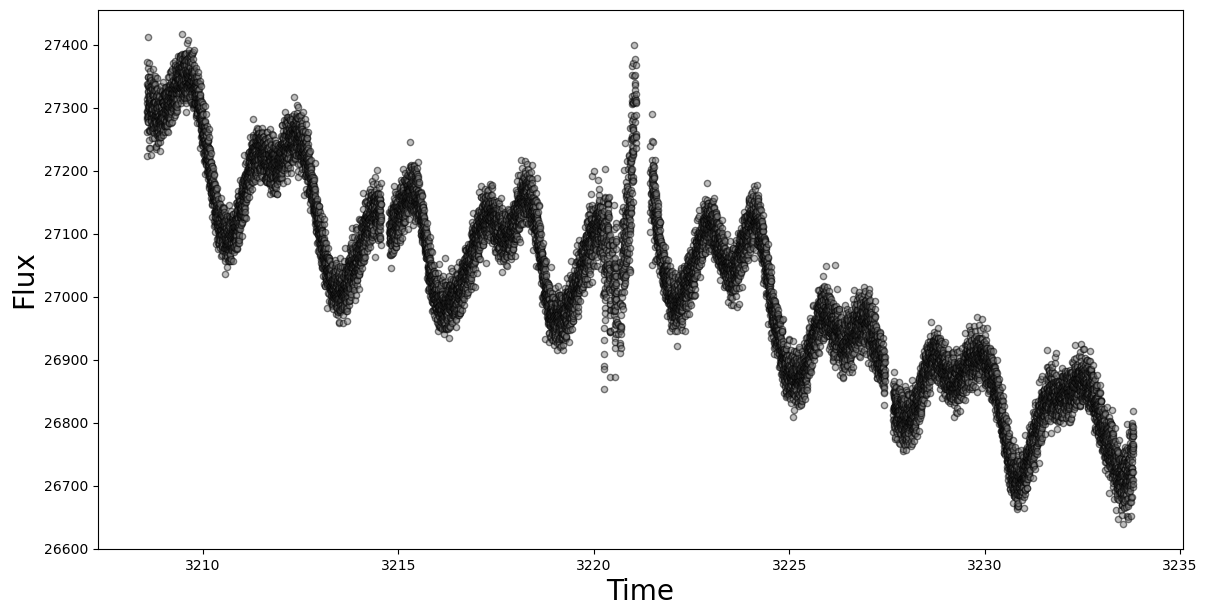

In [107]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [108]:
lightcurves = Observations.filter_products(obs_table, dataproduct_type="timeseries", sequence_number=[44])
lightcurves.rename_column('dataURL', 'dataURI')
lightcurves
print(lightcurves.colnames)

['intentType', 'obs_collection', 'provenance_name', 'instrument_name', 'project', 'filters', 'wavelength_region', 'target_name', 'target_classification', 'obs_id', 's_ra', 's_dec', 'dataproduct_type', 'proposal_pi', 'calib_level', 't_min', 't_max', 't_exptime', 'em_min', 'em_max', 'obs_title', 't_obs_release', 'proposal_id', 'proposal_type', 'sequence_number', 's_region', 'jpegURL', 'dataURI', 'dataRights', 'mtFlag', 'srcDen', 'obsid', 'objID', 'objID1', 'distance']


In [109]:
lightcurves['productFilename'] = ['TESS_Mission_LC_664327433763175424-Sector_0044.fits']

lightcurves

<Table masked=True length=1>
intentType ...                   productFilename                  
   str7    ...                        str51                       
---------- ... ---------------------------------------------------
   science ... TESS_Mission_LC_664327433763175424-Sector_0044.fits

In [110]:
manifest = Observations.download_products(lightcurves, download_dir = 'TESS_Mission_Praesepe_LC/')

INFO: Found cached file TESS_Mission_Praesepe_LC/mastDownload/TESS/tess2021284114741-s0044-0000000026127347-0215-s/TESS_Mission_LC_664327433763175424-Sector_0044.fits with expected size 1776960. [astroquery.query]


In [111]:
from astropy.io import fits

In [112]:
target_lc = fits.open('TESS_Mission_Praesepe_LC/mastDownload/TESS/'+ lightcurves['dataURI'][0].split('/')[2].split('_')[0] + '/TESS_Mission_LC_664327433763175424-Sector_0044.fits')[1]

target_lc.data

FITS_rec([(2500.18724952, 0.00454211, 916364,       nan,      nan,       nan,       nan,       nan,       nan, 168, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,        nan),
          (2500.1886385 , 0.0045422 , 916365,       nan,      nan,       nan,       nan,       nan,       nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,        nan),
          (2500.19002748, 0.00454229, 916366,       nan,      nan,       nan,       nan,       nan,       nan,  32, nan, nan, nan, nan,          nan,        nan,           nan,        nan,        nan,        nan),
          ...,
          (2524.442409  , 0.00554562, 933827, 27819.783, 20.46259, 3433.7922, 7.4664736, 29532.174, 22.095963,   0, nan, nan, nan, nan, 476.71234102, 0.00060341, 1517.41360662, 0.00060533, 0.01203729, 0.0669768 ),
          (2524.44379792, 0.00554565, 933828, 27867.352, 20.46702, 3428.5166, 7.451076 , 29589.045, 22.100746,   0, nan, nan, nan

In [113]:
target_lc.header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                17466 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2457000, days' / column units: Barycenter corrected TESS Julian
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

In [114]:
time = target_lc.data['TIME']
flux = target_lc.data['SAP_FLUX']

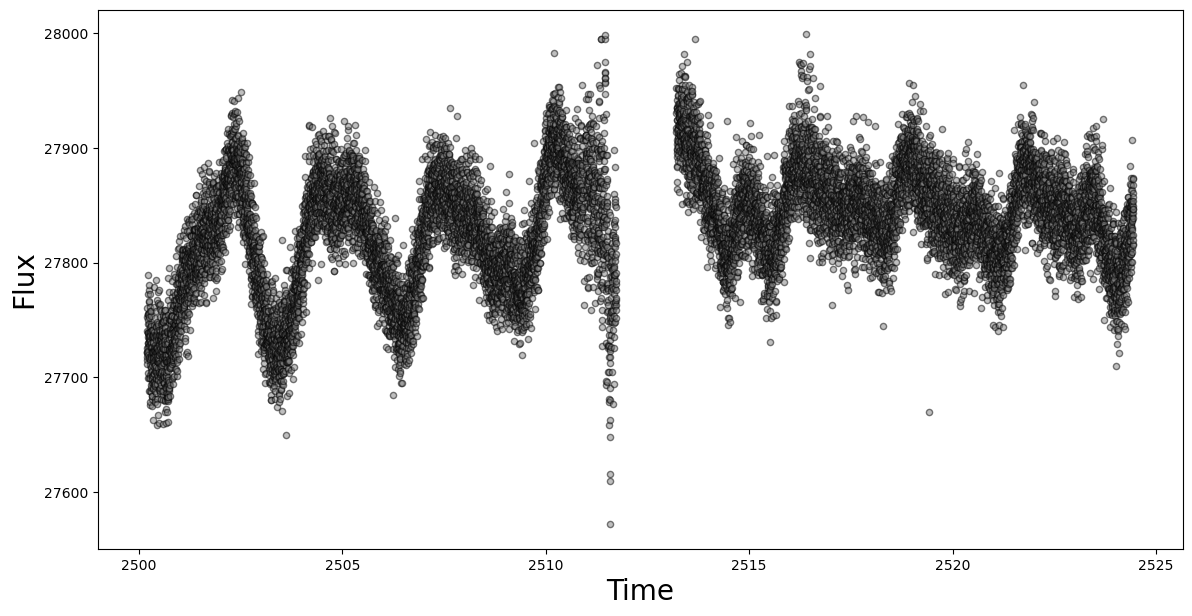

In [115]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(time, flux, c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

In [116]:
#GAIA BP-RP 1.0-1.5

In [117]:
praesepe_index_2 = np.where(curtis_rot['Cluster'] == 'Praesepe')[0]
praesepe_targets_2 = curtis_rot[praesepe_index_2]

# Define the BP-RP range
bp_rp_min = 1.0
bp_rp_max = 1.5

# Filter the targets within the BP-RP range from the Praesepe cluster
filtered_indices_2 = np.where((praesepe_targets_2['BP-RP'] >= bp_rp_min) & (praesepe_targets_2['BP-RP'] <= bp_rp_max))[0]
filtered_targets_2 = praesepe_targets_2[filtered_indices_2]

selected_targets_2 = filtered_targets_2[:3]
print(f"Number of targets in Praesepe cluster between {bp_rp_min} and {bp_rp_max} BP-RP: {len(selected_targets)}")

Number of targets in Praesepe cluster between 1.0 and 1.5 BP-RP: 3


In [118]:
for target_data in selected_targets_2:
    download_tess(target_data, dir_ffi)

Initial files_ffi: []
Downloaded files: ['FFI_Cutouts/661319547906688896/tess-s0045-2-2_130.228470_19.935117_40x40_astrocut.fits', 'FFI_Cutouts/661319547906688896/tess-s0072-2-2_130.228470_19.935117_40x40_astrocut.fits', 'FFI_Cutouts/661319547906688896/tess-s0044-4-4_130.228470_19.935117_40x40_astrocut.fits', 'FFI_Cutouts/661319547906688896/tess-s0046-1-2_130.228470_19.935117_40x40_astrocut.fits']
Filename: FFI_Cutouts/661319547906688896/tess-s0045-2-2_130.228470_19.935117_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0045
Filename: FFI_Cutouts/661319547906688896/tess-s0072-2-2_130.228470_19.935117_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0072
Filename: FFI_Cutouts/661319547906688896/tess-s0044-4-4_130.228470_19.935117_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0044
Filename: FFI_Cutouts/661319547906688896/tess-s0046-1-2_130.228470_19.935117_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0046

In [119]:
for target_data in selected_targets_2:
    lc_list = make_cpm(target_data, dir_lightcurve, dir_ffi)

Initial files_ffi: ['FFI_Cutouts/661319547906688896-Sector_0045.fits', 'FFI_Cutouts/661319547906688896-Sector_0044.fits', 'FFI_Cutouts/661319547906688896-Sector_0072.fits', 'FFI_Cutouts/661319547906688896-Sector_0046.fits']
Filename: FFI_Cutouts/661319547906688896-Sector_0045.fits, Length: 47
Parsed sector from existing file: 
Error parsing sector number from filename: FFI_Cutouts/661319547906688896-Sector_0045.fits Error: invalid literal for int() with base 10: ''
Filename: FFI_Cutouts/661319547906688896-Sector_0044.fits, Length: 47
Parsed sector from existing file: 
Error parsing sector number from filename: FFI_Cutouts/661319547906688896-Sector_0044.fits Error: invalid literal for int() with base 10: ''
Filename: FFI_Cutouts/661319547906688896-Sector_0072.fits, Length: 47
Parsed sector from existing file: 
Error parsing sector number from filename: FFI_Cutouts/661319547906688896-Sector_0072.fits Error: invalid literal for int() with base 10: ''
Filename: FFI_Cutouts/6613195479066888

In [120]:
# open the lightcurve file for Sector 72

lc_table = ascii.read(lc_list[2])

lc_table

<Table length=3320>
       Time              Flux_18_18       ...       Flux_22_22      
     float64              float64         ...        float64        
------------------ ---------------------- ... ----------------------
 2552.076282876147  0.0009751995178319817 ...  0.0034555835046266026
2552.0832278795297 -0.0036149734543347023 ...  -0.001585228401873806
2552.1318429118137 -0.0026938289852243003 ... 0.00043689141475056203
 2552.152677929177  -0.008477679943949212 ...  0.0031363719837607107
 2552.180457955741   0.001116810991602435 ...  0.0026549376587245987
 2552.201292977994   -0.00881080517904742 ...  -0.009844297214037567
               ...                    ... ...                    ...
 2578.661329560993   0.005758886476225754 ... -0.0011551246211155748
2578.6682742719404  -0.002005287950231676 ...   -0.00334902319186247
2578.6752189828867  0.0004964765807340319 ... -0.0004170121938173207
 2578.682163693833  -0.003431834131441368 ...  -0.003698106199552501
  2578.68910840478  0.0020837220635114844 ...   0.005356041174780315
 2578.696053115726  -0.004317771782771301 ... 0.00036248570551473177
 2578.702997826673     0.0044305709434487 ...   0.005419067079208687

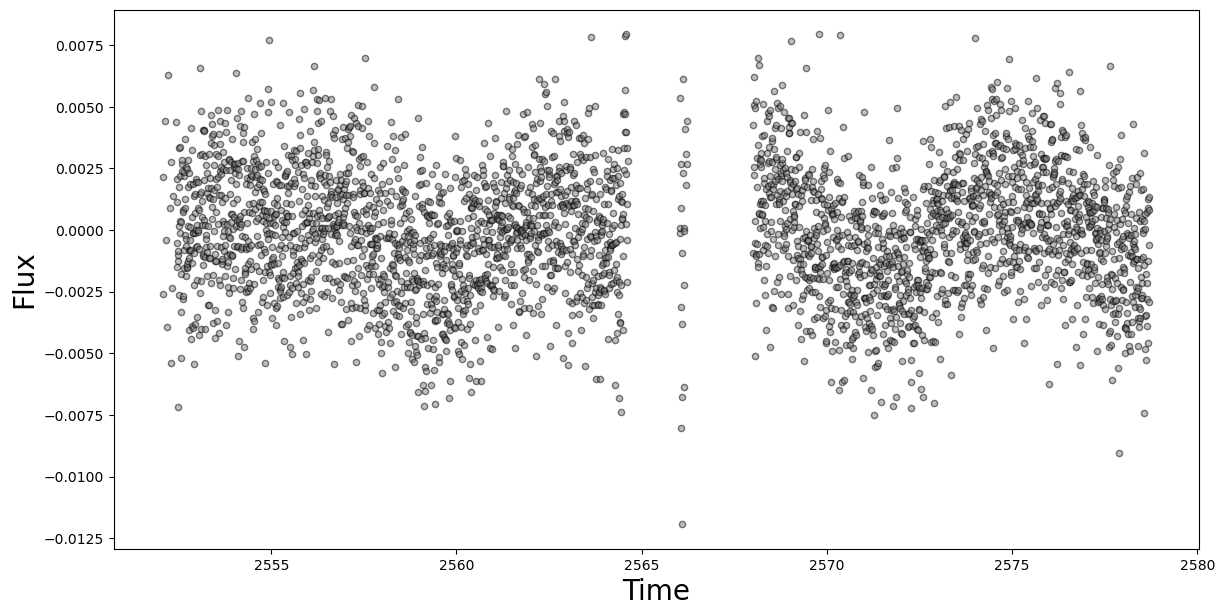

In [121]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

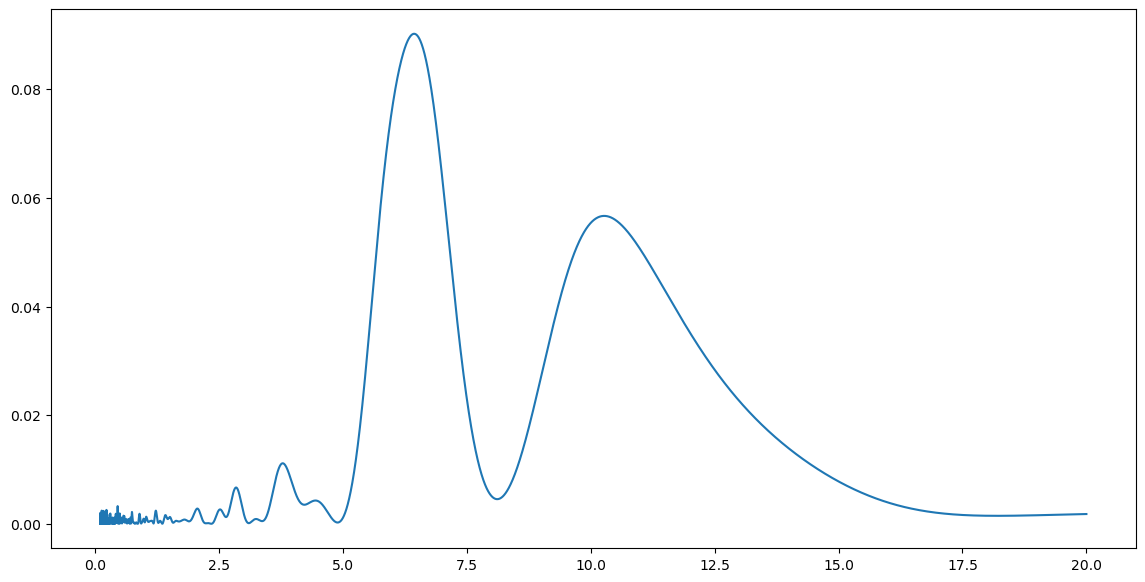

In [122]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [123]:
# open the lightcurve file for Sector 44

lc_table = ascii.read(lc_list[3])

lc_table

<Table length=9577>
       Time              Flux_18_18      ...      Flux_22_22     
     float64              float64        ...       float64       
------------------ --------------------- ... --------------------
3260.1873670193495 -0.010900032640122959 ...  0.08697835358933048
3260.1896820438214    0.1564485733535932 ...  -0.6956356440647156
 3260.191997068409  -0.23711633810526678 ...   0.5756542404665979
3260.1943120928804  -0.02039616016118373 ...    0.375343069833157
 3260.196627117469  -0.27465171993252824 ... -0.13273900907283576
 3260.198942142173  -0.20445682972352586 ...  -0.7108096592181212
               ...                   ... ...                  ...
3285.5715629016936  0.022264274535134645 ...  0.12462455184779148
 3285.573877880996 -0.017827524034464956 ...  0.02270516530595522
3285.5761928602988 -0.006935941657782468 ...  0.02952002992660531
 3285.578507839601   -0.1185717021968231 ... -0.20371670536862216
3285.5808228186706 -0.011510614459585247 ...  0.10569463697997938
3285.5831377979734  -0.11222002084463667 ...  0.13056368384576755
3285.5854527770434   0.02776544530697249 ... -0.06030638770521489

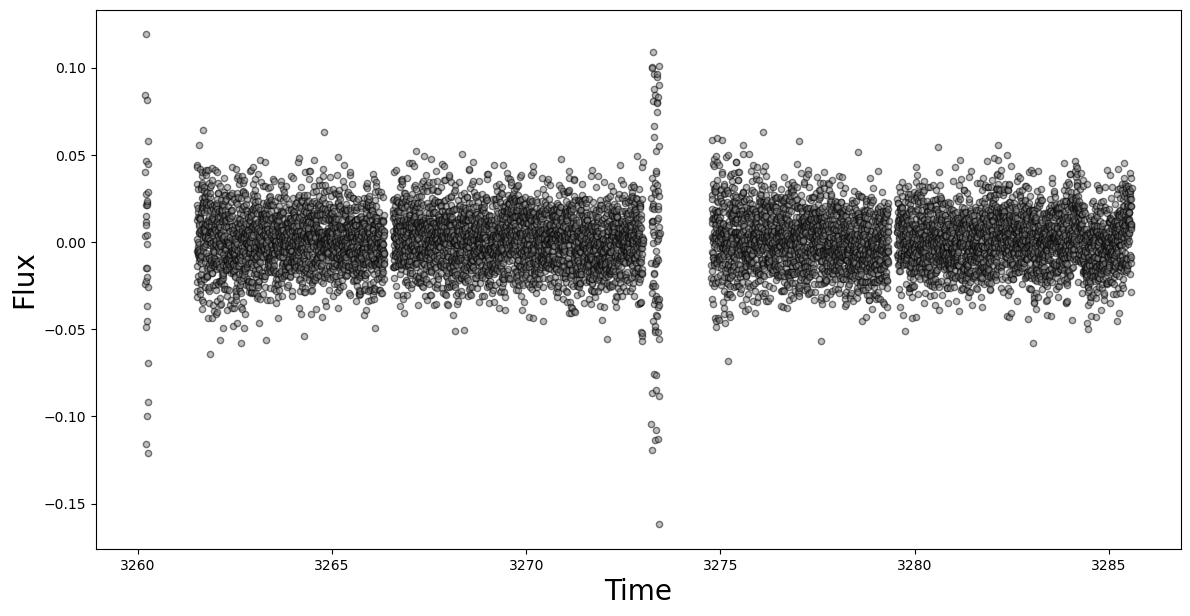

In [124]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

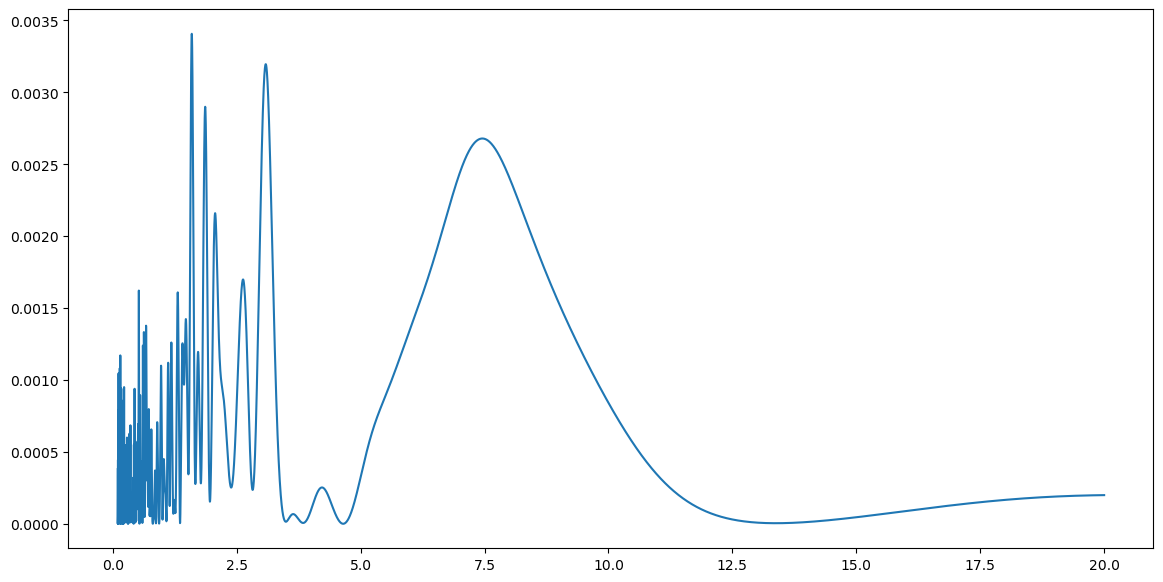

In [125]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [126]:
# open the lightcurve file for Sector 45

lc_table = ascii.read(lc_list[1])

lc_table

<Table length=3121>
       Time              Flux_18_18       ...        Flux_22_22      
     float64              float64         ...         float64        
------------------ ---------------------- ... -----------------------
 2525.796516042703   0.012098688942887126 ...    0.010171022115662787
 2525.845131840259 -0.0025156273378570404 ...    0.006485919000149831
2525.8590220710603  -0.008196052877400994 ...   -0.010750094251145814
 2525.865967186925   0.004411081966654962 ...     0.00274992144586772
2525.8729123030225   0.000943777169529536 ...    0.006647506157480887
 2525.893747653182  0.0008428422970303551 ...   -0.002182976150581162
               ...                    ... ...                     ...
 2550.583439617276  0.0030866088079541595 ...   0.0022905248964397995
 2550.590384560148 -0.0026652065101837596 ...  -0.0005367219932480988
2550.5973295027898   0.002048307120664887 ...   0.0016174531220705113
2550.6042744451975 -0.0018833641113522592 ...  -0.0013384332307364577
2550.6112193873723  0.0013243672923627242 ...    0.004992906478630002
 2550.618164329314 -0.0032607595211891424 ...  -0.0006228076149101675
2550.6251092712555  0.0070553256342519785 ... -0.00030429013937506577

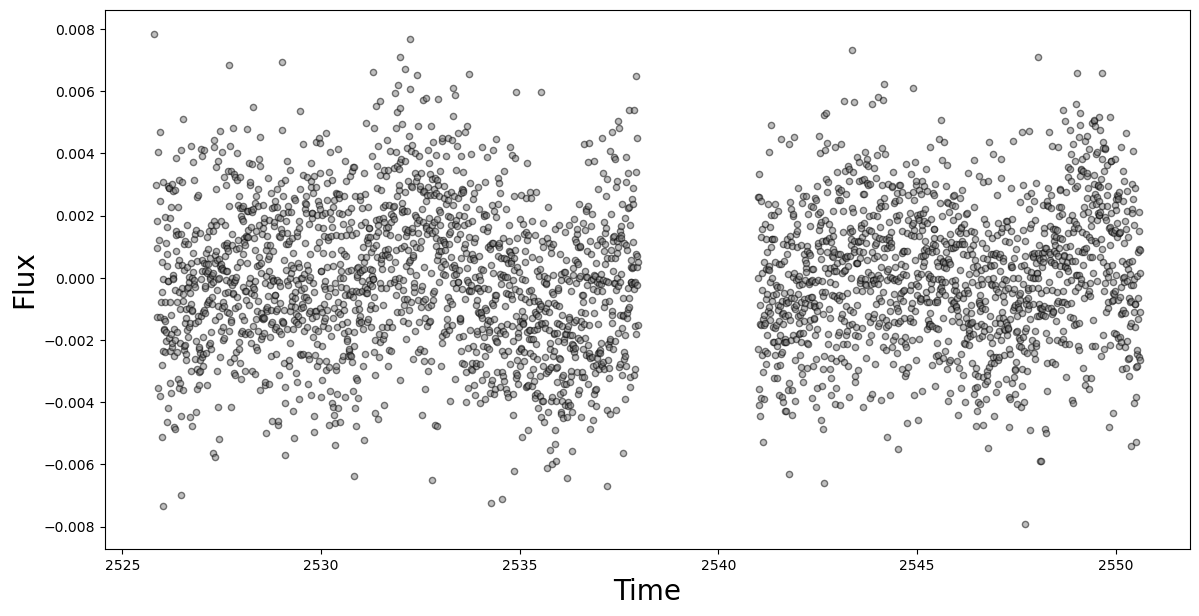

In [127]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

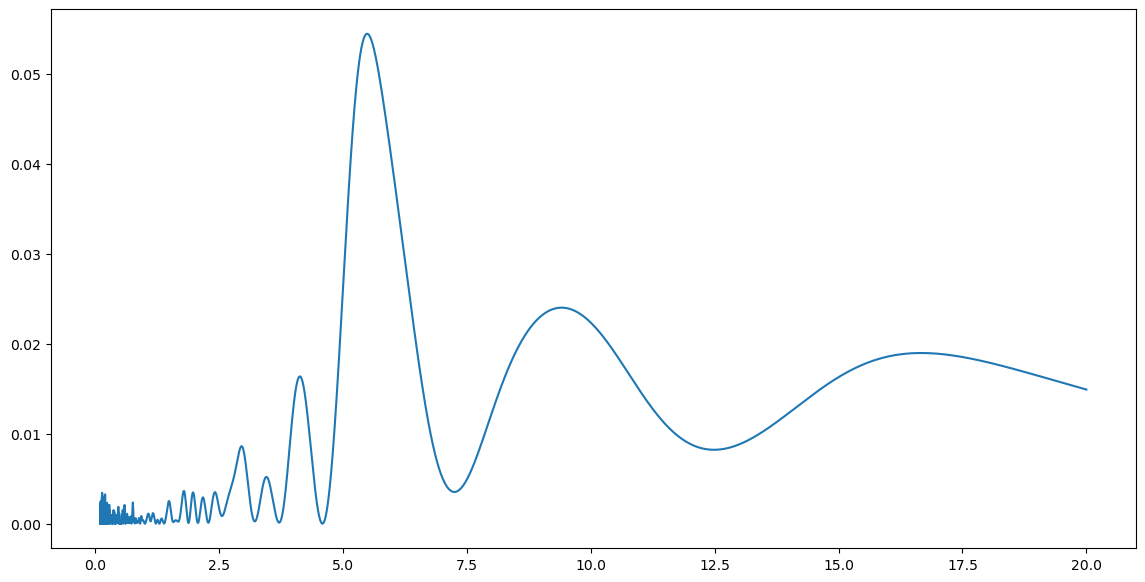

In [128]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [129]:
# open the lightcurve file for Sector 46

lc_table = ascii.read(lc_list[0])

lc_table

<Table length=3261>
       Time              Flux_18_18       ...       Flux_22_22      
     float64              float64         ...        float64        
------------------ ---------------------- ... ----------------------
  2500.18888367721  -0.009888087290610414 ...   0.003201199743241734
 2500.195828747933  0.0009419748053702826 ...   0.001703983901095274
2500.2027738193556  -0.007954552059968645 ...  0.0019018658331981797
 2500.209718891011  -0.005104275258685398 ...  0.0009023773153176151
 2500.216663963131  -0.008090008374276092 ...  0.0013391838642555776
 2500.223609035717  -0.007377779277906615 ...  -0.002126982558400048
               ...                    ... ...                    ...
 2524.392618343175 -0.0007162867743146228 ... -0.0022277189620635296
 2524.399563433457 -0.0023741804252890852 ... -0.0023285240922124306
2524.4065085235197  0.0016805901370920695 ...  5.974119798626831e-05
2524.4134536133656  0.0003451389981437014 ... -0.0030455082683145673
 2524.420398703008   0.004762824680184657 ...  -0.003037787033654732
2524.4273437924167 -0.0012850176153591797 ...  -0.005904453211901806
 2524.434288881622   0.003340280936344975 ... -0.0013979742337710266

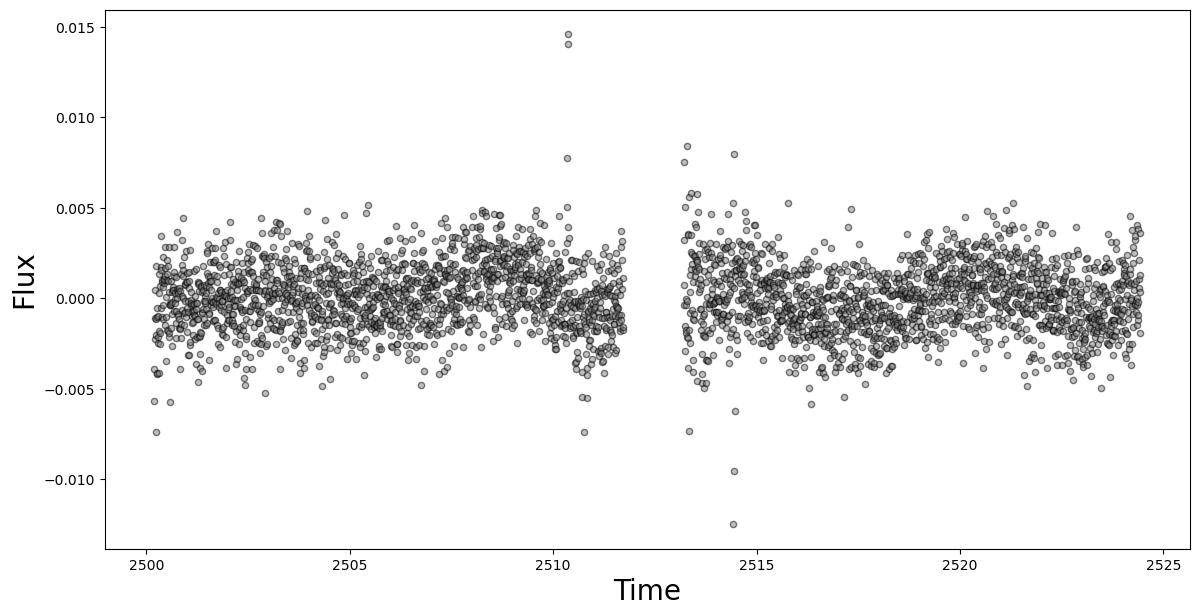

In [130]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

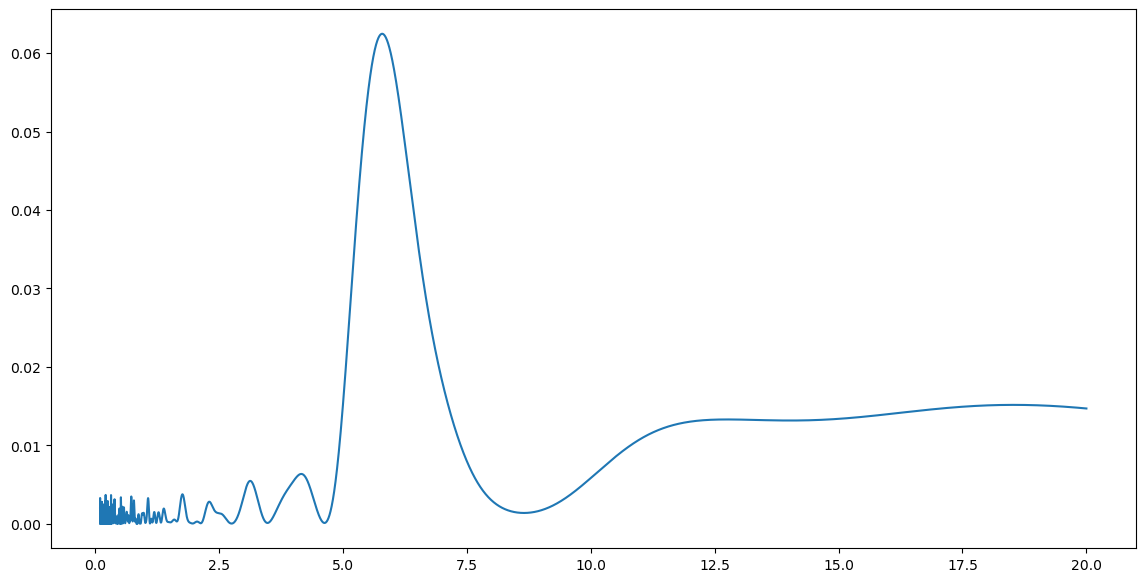

In [131]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [132]:
praesepe_index_3 = np.where(curtis_rot['Cluster'] == 'Praesepe')[0]
praesepe_targets_3 = curtis_rot[praesepe_index_3]

# Define the BP-RP range
bp_rp_min = 1.5
bp_rp_max = 2.0

# Filter the targets within the BP-RP range from the Praesepe cluster
filtered_indices_3 = np.where((praesepe_targets_3['BP-RP'] >= bp_rp_min) & (praesepe_targets_3['BP-RP'] <= bp_rp_max))[0]
filtered_targets_3 = praesepe_targets_3[filtered_indices_3]

selected_targets_3 = filtered_targets_3[:4]
print(f"Number of targets in Praesepe cluster between {bp_rp_min} and {bp_rp_max} BP-RP: {len(selected_targets)}")

Number of targets in Praesepe cluster between 1.5 and 2.0 BP-RP: 3


In [133]:
for target_data in selected_targets_3:
    download_tess(target_data, dir_ffi)

Initial files_ffi: []
Downloaded files: ['FFI_Cutouts/661314570042801280/tess-s0044-4-4_129.904630_19.816045_40x40_astrocut.fits', 'FFI_Cutouts/661314570042801280/tess-s0046-1-2_129.904630_19.816045_40x40_astrocut.fits', 'FFI_Cutouts/661314570042801280/tess-s0045-2-2_129.904630_19.816045_40x40_astrocut.fits', 'FFI_Cutouts/661314570042801280/tess-s0072-2-2_129.904630_19.816045_40x40_astrocut.fits']
Filename: FFI_Cutouts/661314570042801280/tess-s0044-4-4_129.904630_19.816045_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0044
Filename: FFI_Cutouts/661314570042801280/tess-s0046-1-2_129.904630_19.816045_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0046
Filename: FFI_Cutouts/661314570042801280/tess-s0045-2-2_129.904630_19.816045_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0045
Filename: FFI_Cutouts/661314570042801280/tess-s0072-2-2_129.904630_19.816045_40x40_astrocut.fits, Length: 86
Parsed sector from downloaded file: 0072

In [134]:
for target_data in selected_targets_3:
    lc_list = make_cpm(target_data, dir_lightcurve, dir_ffi)

Initial files_ffi: ['FFI_Cutouts/661314570042801280-Sector_0045.fits', 'FFI_Cutouts/661314570042801280-Sector_0044.fits', 'FFI_Cutouts/661314570042801280-Sector_0072.fits', 'FFI_Cutouts/661314570042801280-Sector_0046.fits']
Filename: FFI_Cutouts/661314570042801280-Sector_0045.fits, Length: 47
Parsed sector from existing file: 
Error parsing sector number from filename: FFI_Cutouts/661314570042801280-Sector_0045.fits Error: invalid literal for int() with base 10: ''
Filename: FFI_Cutouts/661314570042801280-Sector_0044.fits, Length: 47
Parsed sector from existing file: 
Error parsing sector number from filename: FFI_Cutouts/661314570042801280-Sector_0044.fits Error: invalid literal for int() with base 10: ''
Filename: FFI_Cutouts/661314570042801280-Sector_0072.fits, Length: 47
Parsed sector from existing file: 
Error parsing sector number from filename: FFI_Cutouts/661314570042801280-Sector_0072.fits Error: invalid literal for int() with base 10: ''
Filename: FFI_Cutouts/6613145700428012

In [201]:
# open the lightcurve file for Sector 72

lc_table = ascii.read(lc_list[2])

lc_table

<Table length=3261>
       Time              Flux_18_18       ...       Flux_22_22      
     float64              float64         ...        float64        
------------------ ---------------------- ... ----------------------
  2500.18888367721 -0.0037164944098289077 ...   0.002587423343712203
 2500.195828747933   0.002249699838094532 ...   0.009917112436313769
2500.2027738193556   0.002569722940498398 ... 0.00010401688875916193
 2500.209718891011  0.0010588775341497936 ...  -0.009082300969935453
 2500.216663963131  -0.001468397915394437 ... -0.0008211923397438703
 2500.223609035717  0.0013741757951133415 ...  0.0010482135500338163
               ...                    ... ...                    ...
 2524.392618343175  0.0014652511223057496 ...  -0.002521138616508517
 2524.399563433457  -0.003906992864462555 ... -0.0011674734506787743
2524.4065085235197   0.000784927081970116 ...  -0.003300455695803839
2524.4134536133656 -0.0029881201847454797 ... -0.0039122390461823475
 2524.420398703008  -0.001058826524430262 ...  0.0007553338423748335
2524.4273437924167 -0.0011028681197680357 ... 4.6907740026358447e-05
 2524.434288881622  0.0017376550266967328 ...   0.003716440679899208

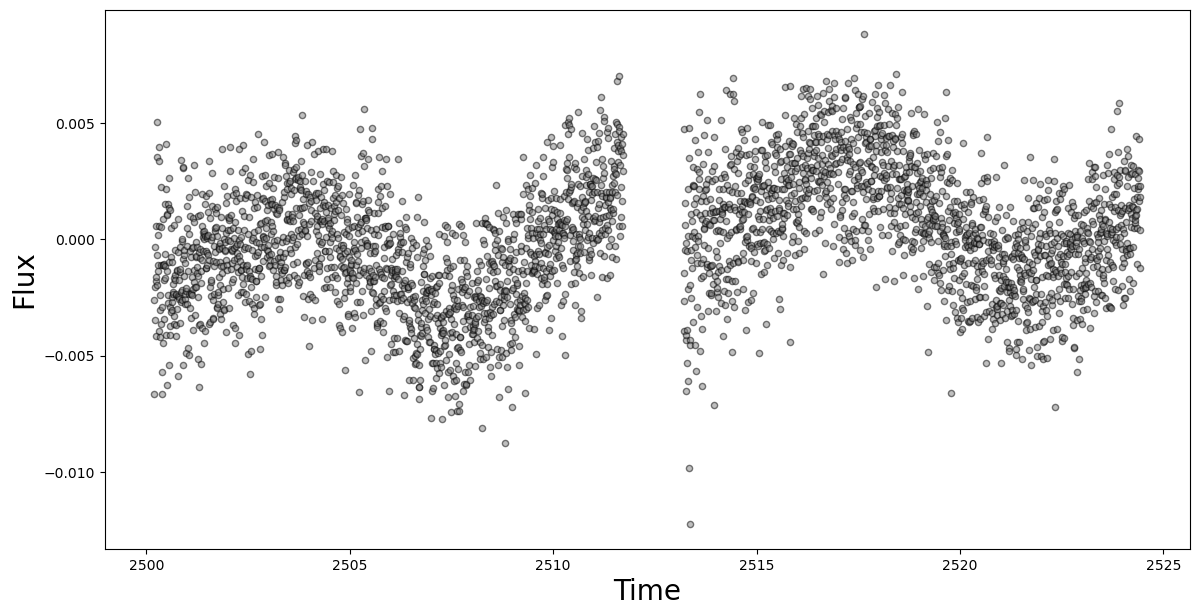

In [203]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

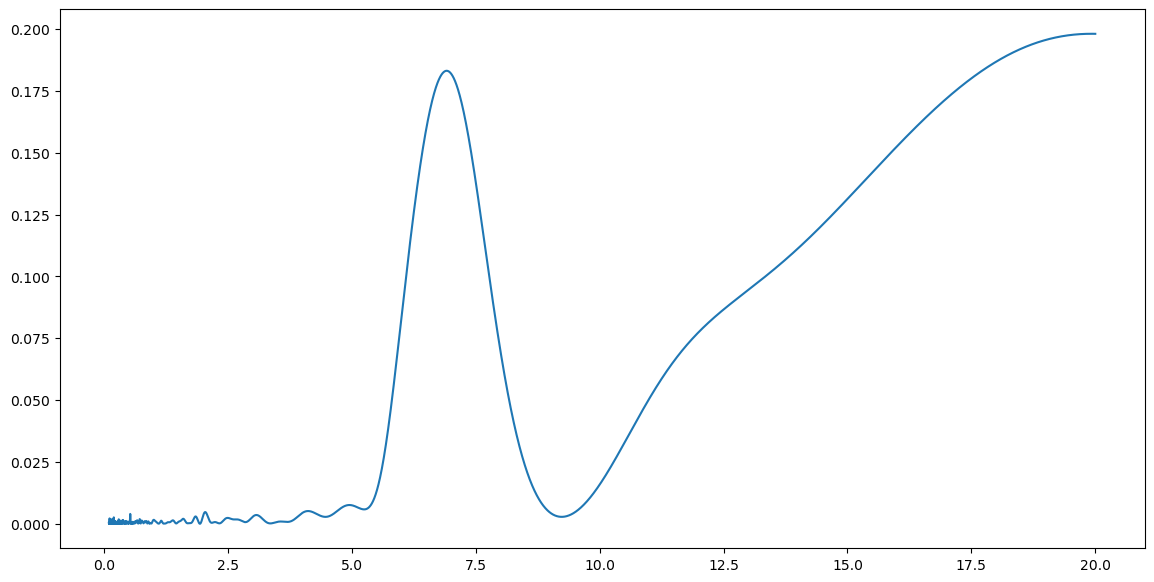

In [205]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [193]:
# open the lightcurve file for Sector 44

lc_table = ascii.read(lc_list[1])

lc_table

<Table length=3121>
       Time              Flux_18_18       ...       Flux_22_22      
     float64              float64         ...        float64        
------------------ ---------------------- ... ----------------------
 2525.796516042703    0.00323309057816612 ...   0.008182405107127977
 2525.845131840259   0.005195698029538676 ...  -0.010482681556017948
2525.8590220710603   0.006910729191989873 ...   0.000894488478549782
 2525.865967186925 -0.0010480614755965512 ... -0.0076476551152264705
2525.8729123030225  -0.010203714716847667 ... -0.0005515846246972878
 2525.893747653182  -0.006522632498862979 ...  -0.009465702537296394
               ...                    ... ...                    ...
 2550.583439617276  0.0006642753094437265 ...   0.002156444078221395
 2550.590384560148   0.007498235997222533 ...  0.0007927450338132275
2550.5973295027898 -0.0013528344391472574 ... -0.0010216221763855865
2550.6042744451975 -0.0012974903520735354 ...  0.0005836496483636808
2550.6112193873723 -0.0001494302875123532 ...  0.0053763725971461215
 2550.618164329314   0.003489204297023915 ... -0.0004023279713420147
2550.6251092712555  -0.002436324471714768 ... -0.0014718553854435115

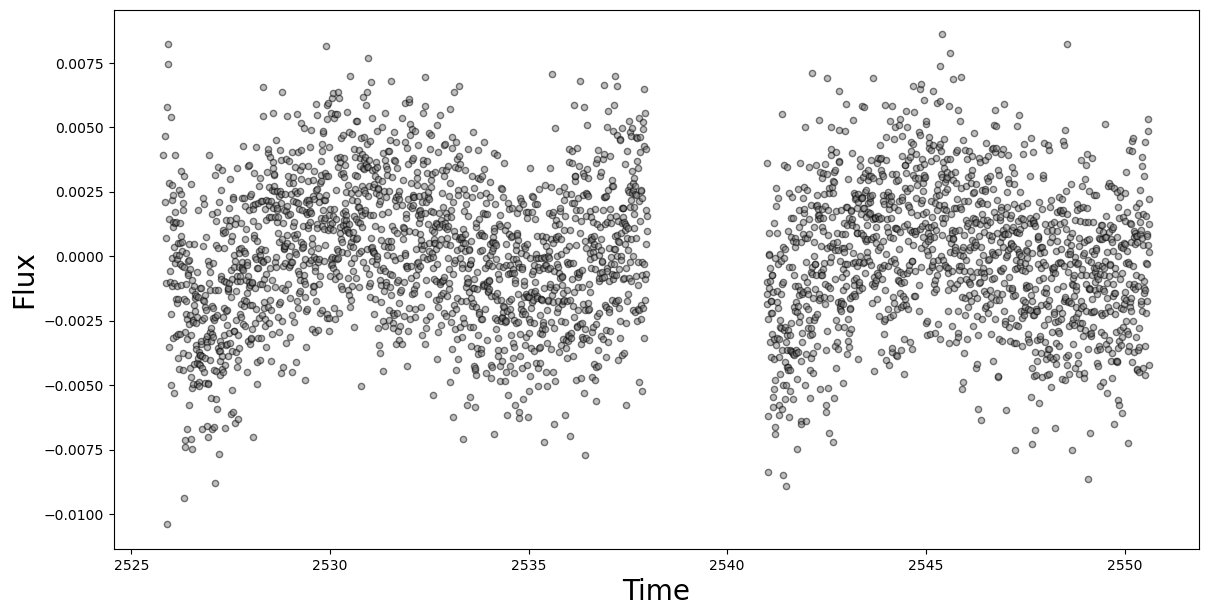

In [195]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

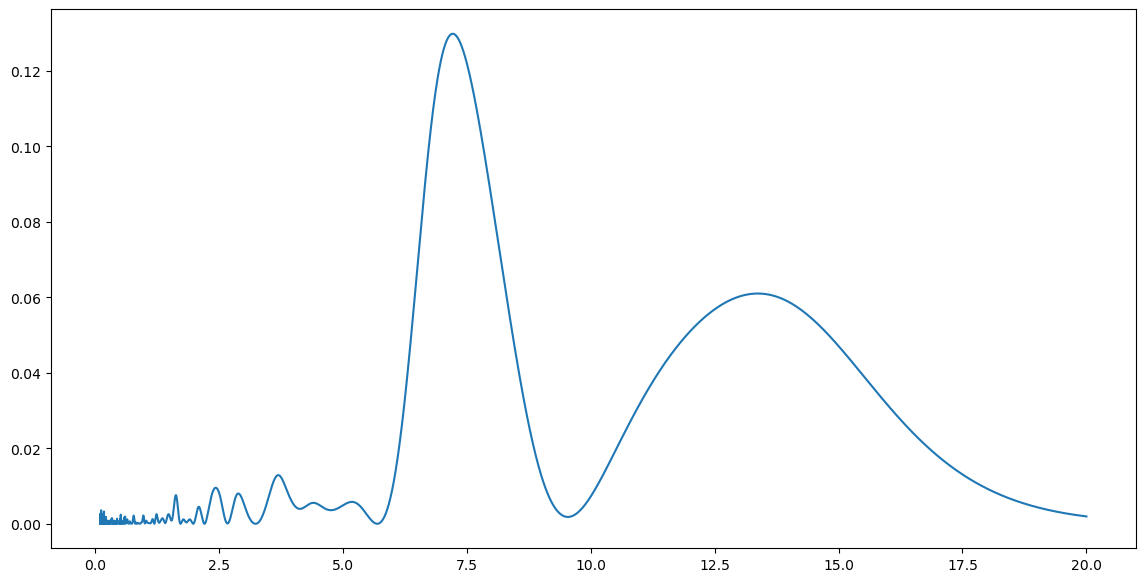

In [197]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [199]:
# open the lightcurve file for Sector 45

lc_table = ascii.read(lc_list[3])

lc_table

<Table length=3320>
       Time               Flux_18_18       ...       Flux_22_22      
     float64               float64         ...        float64        
------------------ ----------------------- ... ----------------------
 2552.076282876147    0.017832200737766257 ...  -0.014467480581371817
2552.0832278795297    -0.01873340461954598 ... -0.0010097492115850315
2552.1318429118137   -0.004410542290248287 ...    0.01845142452689963
 2552.152677929177    0.011378151616624699 ... 0.00021260858714722275
 2552.180457955741   -0.004593831239006363 ... -0.0004276231166411293
 2552.201292977994     0.01503393231299377 ... -0.0013103325420500411
               ...                     ... ...                    ...
 2578.661329560993   -0.001174609641809165 ...   0.005596423843818806
2578.6682742719404  -0.0014067256227351997 ...  0.0013750647838068077
2578.6752189828867   0.0013301296857393097 ...  0.0049500686087291445
 2578.682163693833   0.0024309076639340895 ...  -0.007619815219194819
  2578.68910840478   0.0029099937867969584 ... -0.0003442328535483352
 2578.696053115726 -0.00042407993376716434 ...  -0.005305450236997983
 2578.702997826673   -0.006068234005929575 ... -0.0017308492577419133

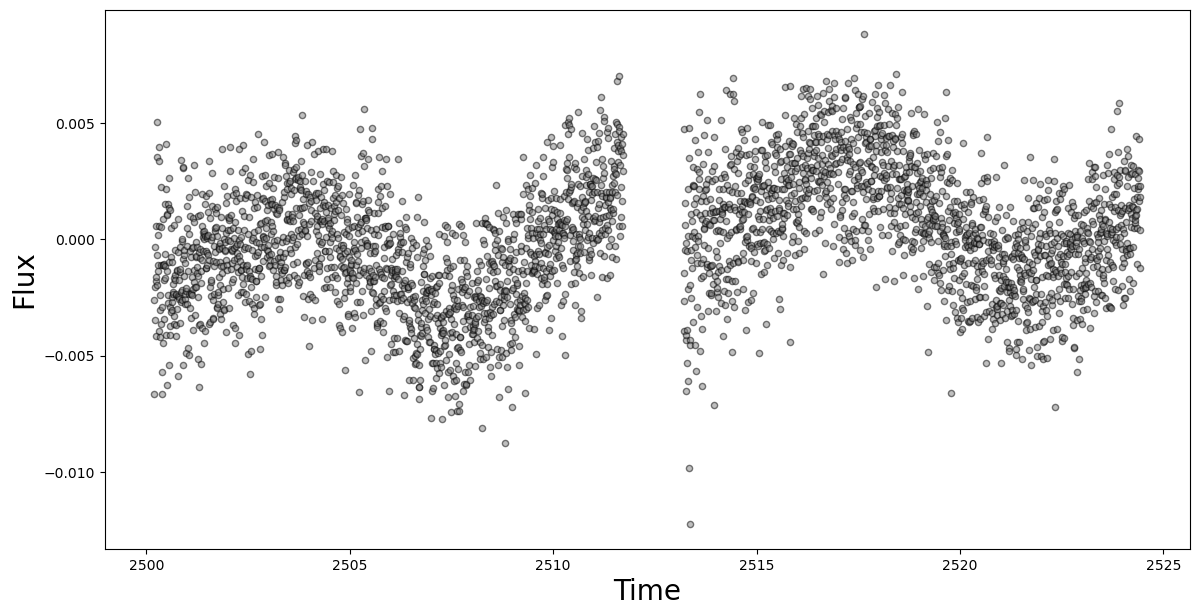

In [207]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

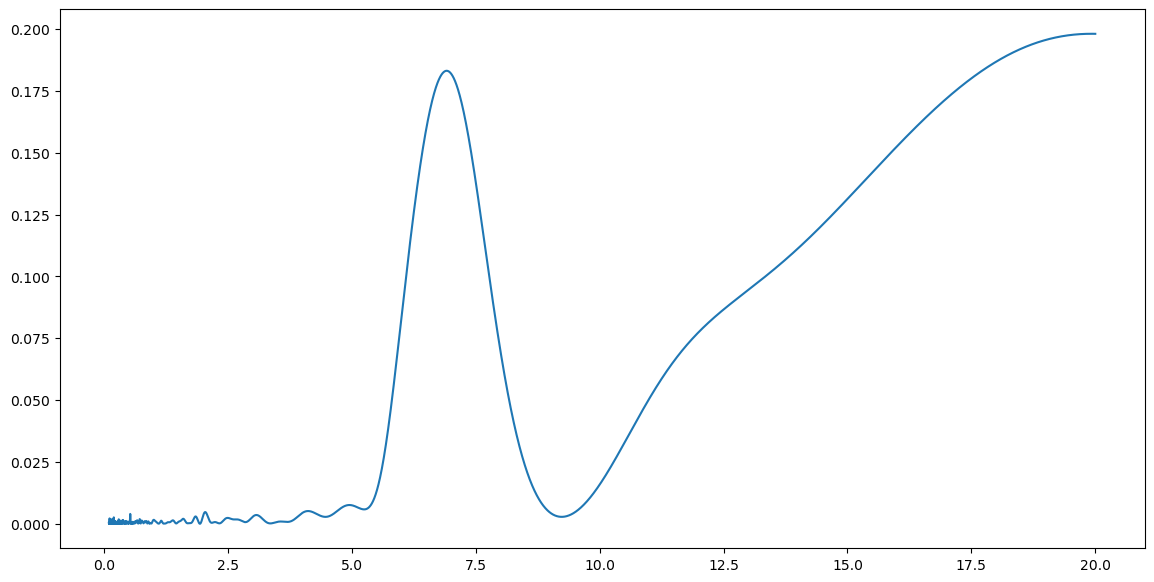

In [209]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()

In [213]:
# open the lightcurve file for Sector 46

lc_table = ascii.read(lc_list[0])

lc_table

<Table length=9577>
       Time               Flux_18_18       ... Flux_22_21       Flux_22_22     
     float64               float64         ...  float64          float64       
------------------ ----------------------- ... ---------- ---------------------
3260.1873670193495     0.07403207450040128 ...        0.0  0.053239814284694376
3260.1896820438214     0.07843098266735637 ...        0.0   -0.6890546222838054
 3260.191997068409     0.27873415261106516 ...        0.0   0.23927442620905026
3260.1943120928804    -0.21571834711770776 ...        0.0   0.13194549216559892
 3260.196627117469    -0.01970480259624452 ...        0.0   0.15762890377492056
 3260.198942142173    -0.12973225629365004 ...        0.0    0.3484714720353139
               ...                     ... ...        ...                   ...
3285.5715629016936    0.043322493020970465 ...        0.0   0.08933235877932358
 3285.573877880996     0.08635478666212593 ...        0.0   0.02825939549499004
3285.5761928602988     0.05823272973772936 ...        0.0   0.07887346064915049
 3285.578507839601     -0.0511906236498517 ...        0.0 7.654583666194537e-06
3285.5808228186706    0.036837365018747834 ...        0.0 -0.012726225766306332
3285.5831377979734    -0.01093095913642042 ...        0.0  -0.08896768638162969
3285.5854527770434 -0.00040498650161083227 ...        0.0  -0.08234150229353676

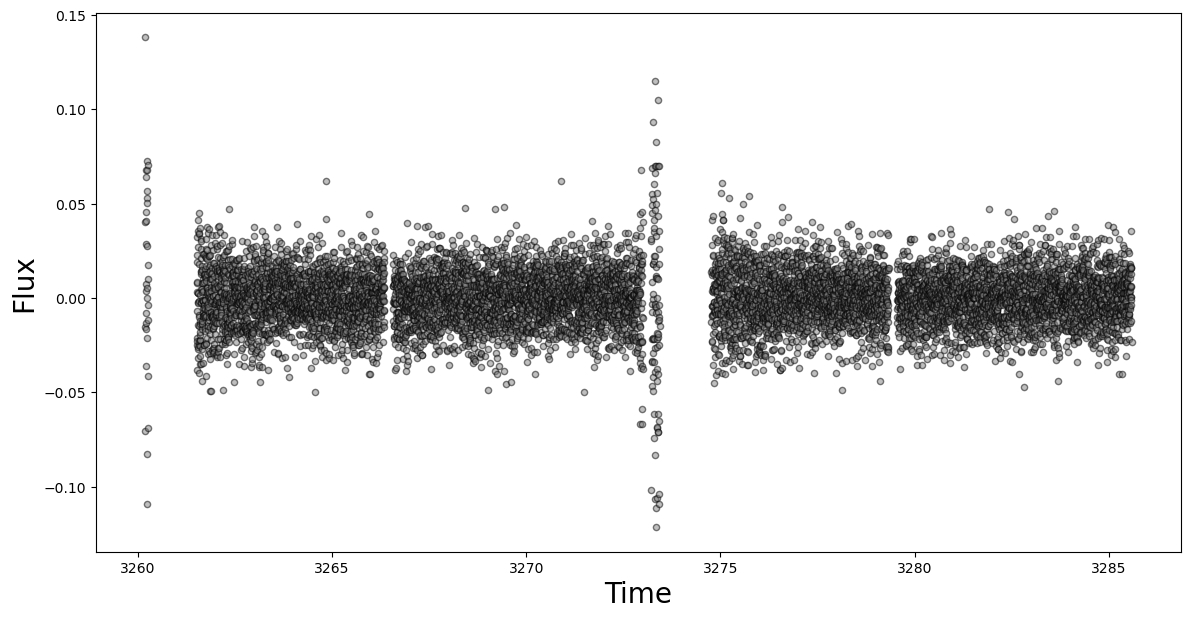

In [215]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(lc_table['Time'], lc_table['Flux_20_20'], c='gray', edgecolor = 'black', s = 20, alpha = 0.5)
ax.set_ylabel('Flux', fontsize = 20)
ax.set_xlabel('Time', fontsize = 20)

plt.show()

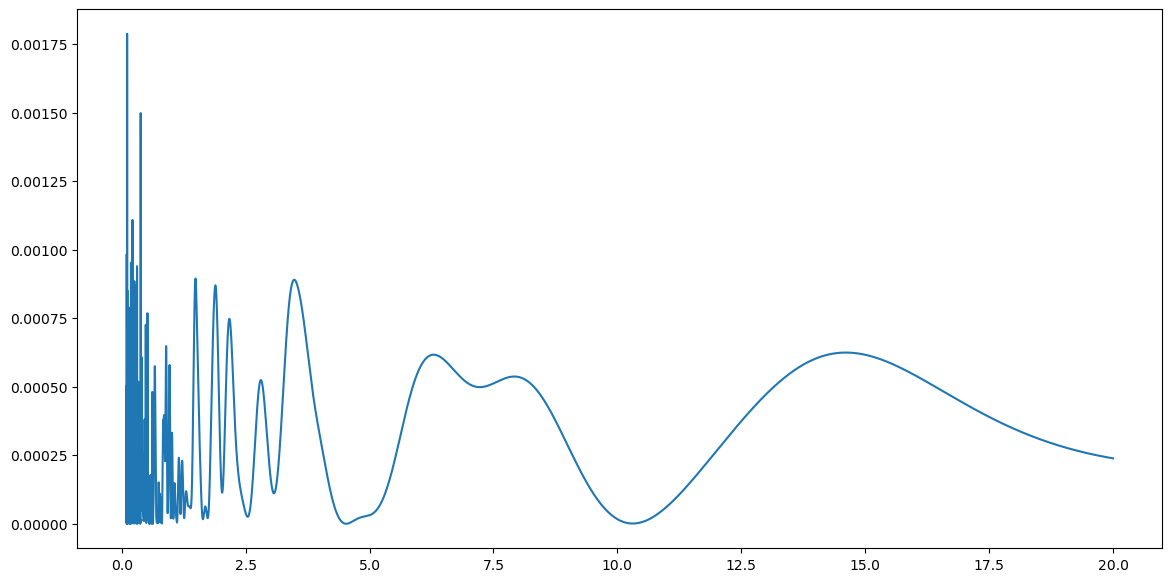

In [217]:
Pmin = 0.1
Pmax = 20

periods_test = np.logspace(np.log10(Pmin),np.log10(Pmax),10000)
freq_test = 1/periods_test

fig, ax = plt.subplots(figsize = (14,7))

time = lc_table['Time']
flux = lc_table['Flux_20_20']
power_test = LombScargle(time, flux).power(freq_test)
ax.plot(periods_test,power_test)

plt.show()